In [5]:
import os
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-08-03 23:20:54.236410: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-03 23:20:54.247584: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-03 23:20:54.331523: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-03 23:20:54.428354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 23:20:54.537847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [6]:
# define
classes=['buildings','street']
train_dir='first_100/seg_train/seg_train'
test_dir='first_100/seg_test/seg_test'
max_images=50 # per class; makes 100 total working w/ 2 classes
image_size=(224,224)

In [7]:
def load_dir(directory,classes,max_images, image_size):
    images=[]
    labels=[]
    for cls_index, cls in enumerate(classes):
        class_dir=os.path.join(directory,cls)
        
        file=[f for f in os.listdir(class_dir) if not os.path.isdir(os.path.join(class_dir, f))]
        file=file[:max_images]
        
        for file in file:
            img_path=os.path.join(class_dir,file)
            try:
                img=tf.io.read_file(img_path)
                img=tf.image.decode_image(img, channels=3) # decode
                img=tf.image.resize(img, image_size) # resize
                images.append(img.numpy())
                labels.append(cls_index) # assign label
            except Exception as e:
                print(f"could not load {img_path}: {e}")
            
    return np.array(images),np.array(labels)

In [8]:
train_images, train_labels = load_dir(train_dir, classes, max_images, image_size)
test_images, test_labels = load_dir(test_dir, classes, max_images, image_size)

In [54]:
# already loaded in before and not directly from directory, this creates dataset from arrays
def create_dataset(images,labels,batch_size=10):
    
    dataset=tf.data.Dataset.from_tensor_slices((images,labels))
    
    #shuffle
    dataset=dataset.shuffle(buffer_size=len(images)).batch(batch_size)
    
    return dataset

In [71]:
def split_data(images,labels,val_split=0.2):

    # split training into train and validation
    num_val=int(val_split*len(images))
    val_images, val_labels=images[num_val:], labels[num_val:]
    train_images, train_labels=images[num_val:], labels[num_val:]
    
    return train_images, train_labels, val_images, val_labels

In [72]:
train_images, train_labels, val_images, val_labels = split_data(train_images, train_labels, val_split=0.2)

# total number of files working with 
total_f = len(train_images) + len(test_images)
print(f"Found {total_f} files belonging to {len(classes)} classes.")

# number of files used for training and validation
print(f"Using {len(train_images)} files for training.")
print(f"Using {len(val_images)} files for validation.")

Found 164 files belonging to 2 classes.
Using 64 files for training.
Using 64 files for validation.


In [73]:
train_ds = create_dataset(train_images, train_labels, batch_size=10)
val_ds = create_dataset(val_images, val_labels, batch_size=10)

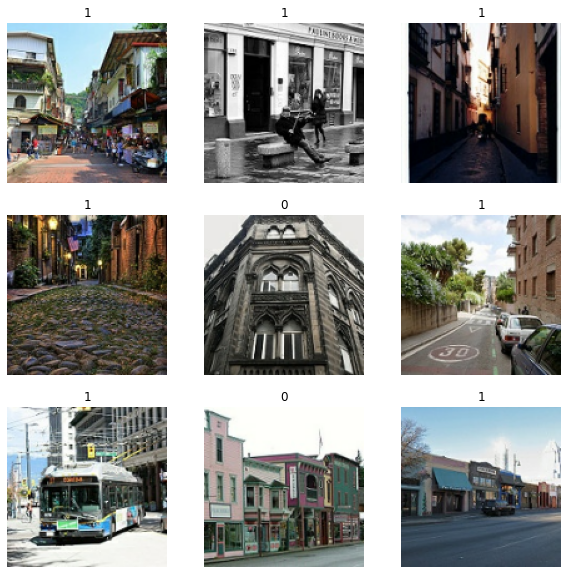

In [74]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [75]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

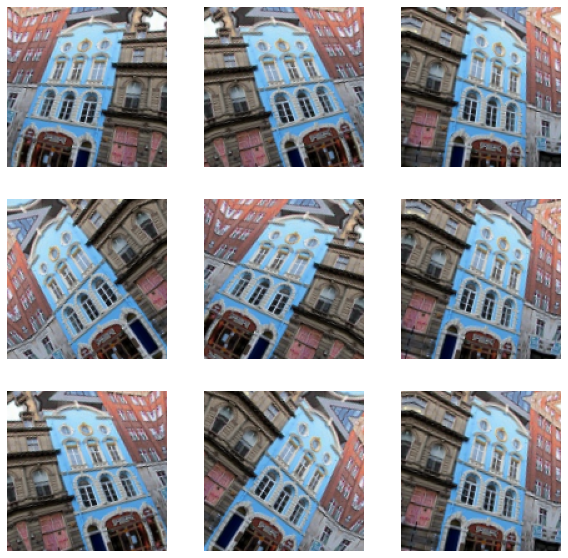

In [76]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [77]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)